In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE
from captum.attr import IntegratedGradients

## 1. 모델 구성하기

In [82]:
data = pd.read_csv('./TrafficData/4-Copy1.csv')
data = data['volumn']
sequence_length = 1440
pred_len = 1

<AxesSubplot: >

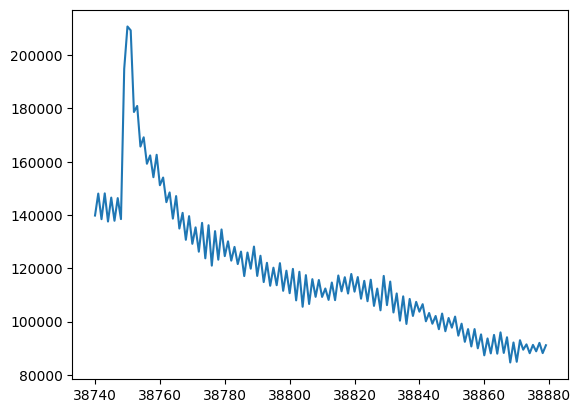

In [83]:
data.iloc[38800-60:].plot()

In [84]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq_len = 1440
        self.pred_len = 1
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x) 

In [85]:
from torch import FloatTensor as FloatTensor

In [86]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length-pred_len):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [87]:
split = 10080
x_train,y_train = seq_data(data.iloc[:-split],sequence_length,pred_len)

In [88]:
batch_size = 64
train_dataset = TensorDataset(x_train,y_train)
training = DataLoader(train_dataset,batch_size= batch_size)

In [89]:
seed = 42

In [90]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0")
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100
criterion = SMAPE()

In [91]:
n= len(training)

In [92]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    running_loss = 0.0

Epoch [1]/[100] running accumulative loss across all batches: 42.193
Epoch [21]/[100] running accumulative loss across all batches: 41.823
Epoch [41]/[100] running accumulative loss across all batches: 42.617
Epoch [61]/[100] running accumulative loss across all batches: 29.944
Epoch [81]/[100] running accumulative loss across all batches: 38.356


## 2. Test 데이터 셋을 만들고 나서 이를 이용해서 IG를 이용해서 attribution 구하기

In [93]:
x_train

tensor([[[104771., 101830., 100160.,  ..., 103284., 104557., 105220.]],

        [[101830., 100160., 100484.,  ..., 104557., 105220., 105250.]],

        [[100160., 100484.,  97533.,  ..., 105220., 105250., 102182.]],

        ...,

        [[ 85870.,  82298.,  85843.,  ...,  91668.,  87325.,  91681.]],

        [[ 82298.,  85843.,  85797.,  ...,  87325.,  91681.,  88167.]],

        [[ 85843.,  85797.,  90281.,  ...,  91681.,  88167.,  89379.]]],
       device='cuda:0')

## X_test 
X_test는 실제로 train set이 아닌 validation set이다.

In [ ]:
X_test = torch.FloatTensor(data.iloc[-split-sequence_length:-split].values).to(device)
# X_train의 마지막 인덱스에서 sequece_length만큼 뒤에 부분을 잘라오기
X_test = X_test.view(1,1,sequence_length)

In [95]:
ig = IntegratedGradients(model)                        

In [96]:
ig_attr_test = ig.attribute(X_test,n_steps = 50,) 
# attribute의 주요 parameter로는 inputs, baselines, target, n_steps등이 있다.

# input의 dimension 0는 sample의 개수를 의미한다.

# baseline을 지정해주지 않는다면 내부적으로 input tensor에 해당하는 zero tensor를 사용한다.

# n_steps는 계산상에서 Sigma의 step을 지정해준다.

# target은 회귀에서는 쓰이지 않고 classification에서 분류의 target index를 정할때 사용한다.

In [97]:
print(ig_attr_test.size())

torch.Size([1, 1, 1440])


## 3. attribution plot 그려서 파악하기

In [98]:
ig_attr_test = ig_attr_test.cpu().detach().numpy()

In [99]:
ig_attr_test = ig_attr_test.reshape(-1)

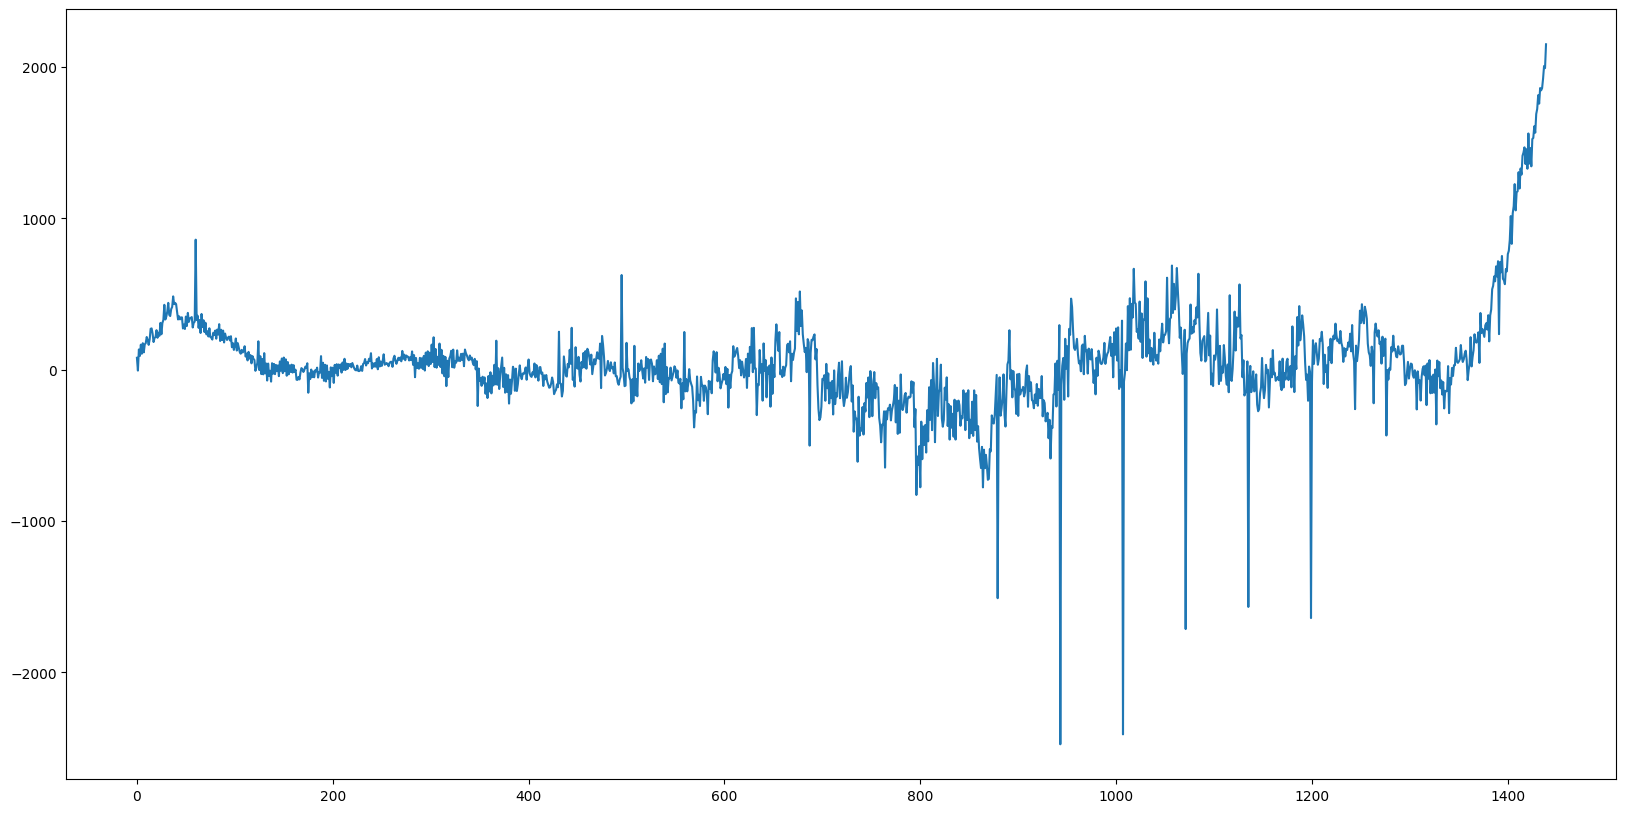

In [100]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(1440),ig_attr_test)

attribution의 seasonality가 보이는 것과 최근의 영향을 더욱 많이 반영하는 것을 확인할 수 있다.<br>
NoiseTunnel을 사용하여 attribution의 잡음을 한번 제거해서 살펴보겠다.

## 4. NoiseTunnel을 사용해서 attribution구하기

In [101]:
from captum.attr import NoiseTunnel

In [102]:
nt_ig = NoiseTunnel(ig)
nt_ig_attr_test = nt_ig.attribute(X_test)

In [103]:
nt_ig_attr_test = nt_ig_attr_test.cpu().detach().numpy().reshape(-1)

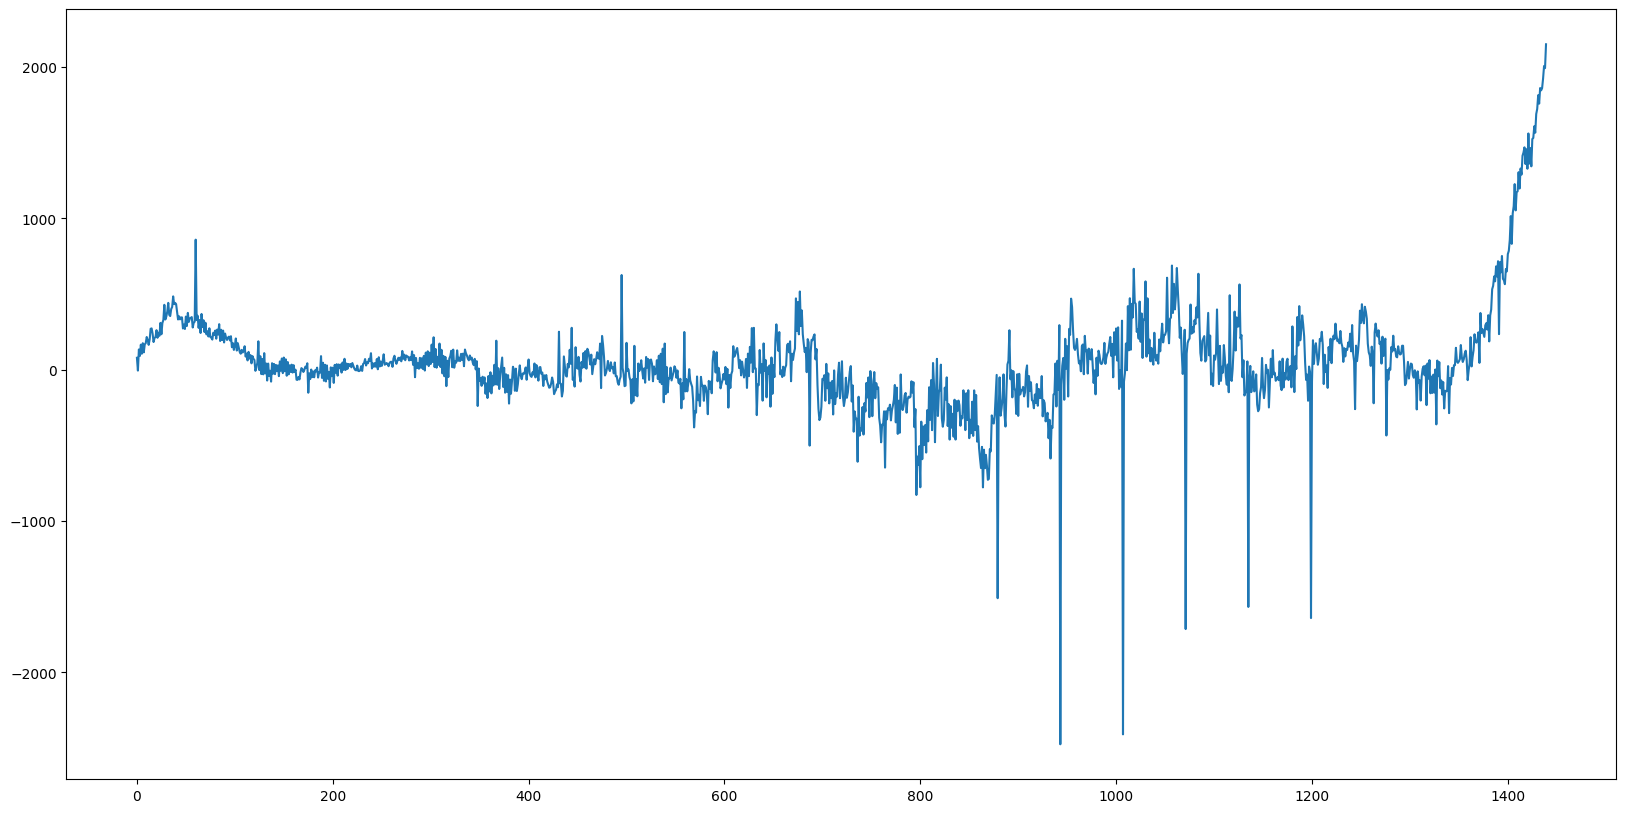

In [104]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(1440),nt_ig_attr_test)

### &rightarrow;NoiseTunnel을 사용해도 크게 결과가 달라지지는 않았다.

## 5. 현재 모델을 통해서 Test set에 대한 결과 내보기

In [105]:
pred = model(X_test)
pred = pred.cpu().detach().view(-1,1)
pred

tensor([[76949.6406]])

In [106]:
target = data.iloc[-split]
target = FloatTensor([target]).view(-1,1)
target

tensor([[90520.]])

In [107]:
first_result = criterion(pred,target).item()*100
first_result 

16.206350922584534

## 6. attribution의 최근에 솟아오르기 시작한 Part의 인덱스찾기

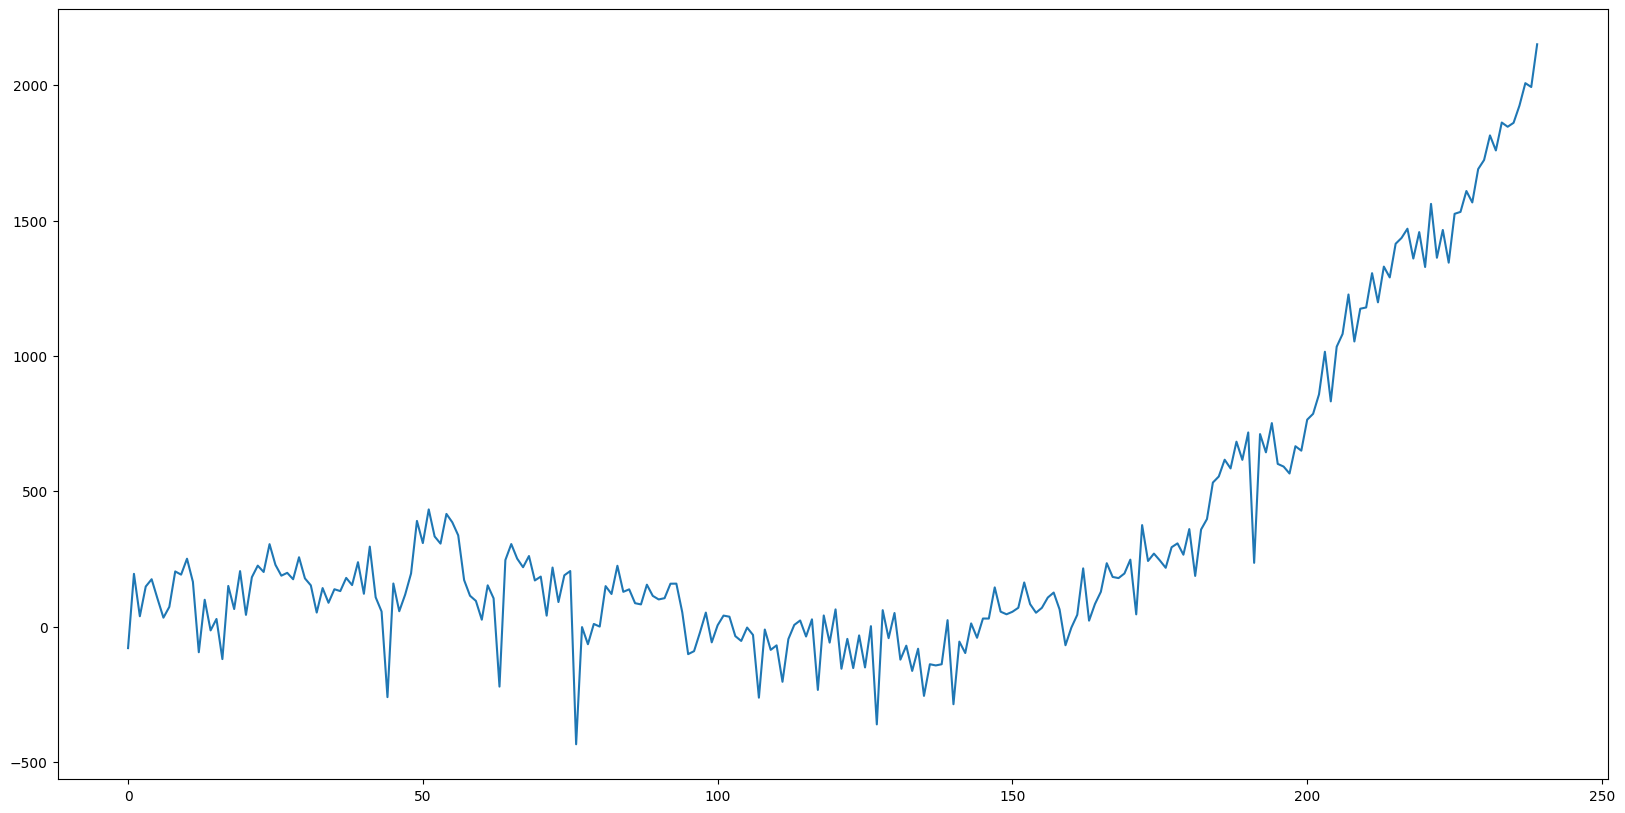

In [108]:
# 최근 240개의 index에대해서 살펴보기
plt.figure(figsize=(20,10))
plt.plot(np.arange(240),nt_ig_attr_test[-240:])
## 대략 -120부터 시작이 됐음

## 7. attribution이 0보다 큰 인덱스만을 이용해서 값 예측해보기

### parameter추출 연습

## model.parameters()/model.children()/model.named_children() -> iterator

In [ ]:
for param in model.parameters():
    print(param)
    
# 두번째 파라미터는 bias

In [110]:
for child in model.children():
    print("child",child)

child Linear(in_features=1440, out_features=1, bias=True)


In [111]:
for step,param in model.named_children():
    print(step,param)   

first_layer Linear(in_features=1440, out_features=1, bias=True)


### 모델 파라미터 변경하기
참고: https://velog.io/@olxtar/PyTorch-class%EB%A1%9C-%EC%83%9D%EC%84%B1%EB%90%9C-model%EC%9D%98-layer-weights-%EC%A0%91%EA%B7%BC%EB%B2%95

In [112]:
df = pd.DataFrame({'attribution':nt_ig_attr_test})
df

,attribution
0,78.814694
1,-5.722514
2,133.683525
3,91.072364
4,165.484674
...,...
1435,1860.919755
1436,1924.544805
1437,2007.469950
1438,1993.231181


In [113]:
idx_under_0 = df[df['attribution']<0].index

## model.get_parameter()

In [114]:
model.get_parameter('first_layer.weight')

Parameter containing:
tensor([[ 8.7298e-04, -6.6356e-05,  1.5479e-03,  ...,  2.2460e-02,
          2.2597e-02,  2.3695e-02]], device='cuda:0', requires_grad=True)

In [115]:
inital_weight = model._modules['first_layer'].weight.detach()

In [116]:
temp_arr = model.get_parameter('first_layer.weight').detach().cpu().numpy().reshape(-1)

In [117]:
temp_arr[idx_under_0]=0
temp_arr

array([0.00087298, 0.        , 0.00154787, ..., 0.02246029, 0.02259688,
       0.02369476], dtype=float32)

In [118]:
new_weight = torch.FloatTensor(temp_arr).view(1,-1)
new_weight = new_weight.to(device)
new_weight.requires_grad = True

In [119]:
new_weight

tensor([[0.0009, 0.0000, 0.0015,  ..., 0.0225, 0.0226, 0.0237]],
       device='cuda:0', requires_grad=True)

In [120]:
for child in model.children():
    print(child.weight)

Parameter containing:
tensor([[ 8.7298e-04, -6.6356e-05,  1.5479e-03,  ...,  2.2460e-02,
          2.2597e-02,  2.3695e-02]], device='cuda:0', requires_grad=True)


### model._modules를 적용하면 Model의 구성이 ordered_dict로써 반환된다.

In [121]:
model._modules

OrderedDict([('first_layer',
              Linear(in_features=1440, out_features=1, bias=True))])

In [122]:
model._modules['first_layer'].bias

Parameter containing:
tensor([0.0002], device='cuda:0', requires_grad=True)

In [123]:
model._modules['first_layer'].weight.data = new_weight

In [124]:
model._modules['first_layer'].weight

Parameter containing:
tensor([[0.0009, 0.0000, 0.0015,  ..., 0.0225, 0.0226, 0.0237]],
       device='cuda:0', requires_grad=True)

In [125]:
df.iloc[:-120].describe()

,attribution
count,1320.000000
mean,4.736806
std,243.380976
min,-2475.822469
25%,-91.259233
50%,18.078814
75%,126.227017
max,859.622024


### 같은 데이터로 예측 수행하기

In [126]:
(model._modules['first_layer'].weight == 0).sum()

tensor(615, device='cuda:0')

In [127]:
pred2 = model(X_test)
pred2 = pred2.cpu().detach().view(-1,1)
second_result = criterion(pred2,target).item()*100
second_result

67.10067987442017

### RESULT 1
attribution이 0보다 작은 PART는 0으로 바꾸면 결과가 너무 커진다.<br>
Minus 부호의 attribution이 결과의 크기를 잡아준다.

## 8. 솟아오르기 시작한 부분으로 예측해보기

In [133]:
df = pd.DataFrame({'attribution':nt_ig_attr_test})
df

,attribution
0,78.814694
1,-5.722514
2,133.683525
3,91.072364
4,165.484674
...,...
1435,1860.919755
1436,1924.544805
1437,2007.469950
1438,1993.231181


In [134]:
df.describe()

,attribution
count,1440.000000
mean,53.437288
std,342.496224
min,-2475.822469
25%,-82.835923
50%,28.038968
75%,154.620820
max,2151.108688


<AxesSubplot: ylabel='attribution'>

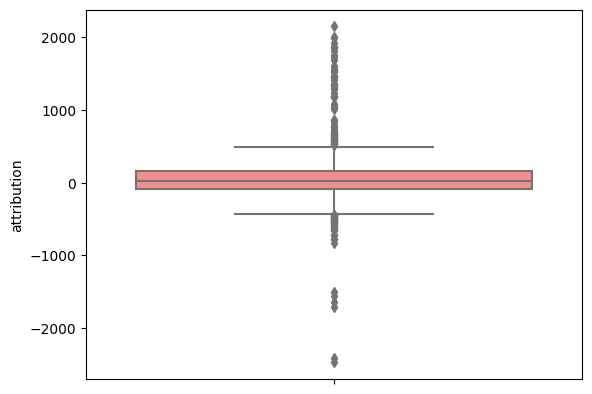

In [135]:
sns.boxplot(data=df, y='attribution',palette = 'spring')

In [136]:
dominant_attr_weight = model._modules['first_layer'].weight.data.detach().\
                        cpu().numpy().reshape(-1)
dominant_attr_weight[:-120] = 0
dominant_attr_weight = FloatTensor(dominant_attr_weight).view(1,-1).to(device)
dominant_attr_weight.requires_grad = True
dominant_attr_weight

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0225, 0.0226, 0.0237]],
       device='cuda:0', requires_grad=True)

In [137]:
(dominant_attr_weight==0).sum()

tensor(1341, device='cuda:0')

In [138]:
model.get_parameter('first_layer.weight').data

tensor([[0.0009, 0.0000, 0.0015,  ..., 0.0225, 0.0226, 0.0237]],
       device='cuda:0')

In [139]:
model.get_parameter('first_layer.weight').data = dominant_attr_weight
model.get_parameter('first_layer.weight').data

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0225, 0.0226, 0.0237]],
       device='cuda:0')

In [143]:
pred3

tensor([[73308.5156]])

In [142]:
pred3 = model(X_test)
pred3 = pred3.cpu().detach().view(-1,1)
third_result = criterion(pred3,target).item()*100
third_result

21.011584997177124

### Result2
예측시점에서 가까운 시점이 확실하게 영향을 크게 미침을 파악할 수 있다.

## 9. attribution이 0인 부분을 제거하고 예측해보기
### -> compact하게 0인 부분은 없기 때문에 Q1~Q3를 제거하고 예측

In [181]:
df.describe()

,attribution
count,1440.000000
mean,53.437288
std,342.496224
min,-2475.822469
25%,-82.835923
50%,28.038968
75%,154.620820
max,2151.108688


In [171]:
inital_weight.requires_grad = True
inital_weight

tensor([[ 8.7298e-04, -6.6356e-05,  1.5479e-03,  ...,  2.2460e-02,
          2.2597e-02,  2.3695e-02]], device='cuda:0', requires_grad=True)

In [172]:
initial_weight = inital_weight
initial_weight

tensor([[ 8.7298e-04, -6.6356e-05,  1.5479e-03,  ...,  2.2460e-02,
          2.2597e-02,  2.3695e-02]], device='cuda:0', requires_grad=True)

In [173]:
model._modules['first_layer'].weight.data=initial_weight

In [174]:
model._modules['first_layer'].weight.data

tensor([[ 8.7298e-04, -6.6356e-05,  1.5479e-03,  ...,  2.2460e-02,
          2.2597e-02,  2.3695e-02]], device='cuda:0')

In [208]:
## Numpy Value error 백과사전 파일 참고
# q1 = -82.835923
# q3 = 154.620820
# zero_attr_index = nt_ig_attr_test[(nt_ig_attr_test<q1) | (nt_ig_attr_test > q3)]
# zero_attr_index

In [281]:
q1 = -82.835923
q3 = 154.620820
zero_attr_index = df[(df['attribution']>q1) & (df['attribution']<q3)].index
zero_attr_index                     

Int64Index([   0,    1,    2,    3,    5,    7,   97,   99,  102,  104,
            ...
            1356, 1357, 1358, 1359, 1360, 1361, 1363, 1364, 1365, 1371],
           dtype='int64', length=720)

In [217]:
zero_attr_index.shape

(720,)

In [219]:
zero_attr_weight = model._modules['first_layer'].weight.data.detach().\
                        cpu().numpy().reshape(-1)
zero_attr_weight[zero_attr_index] = 0 #q1과 q3사이에 있는 부분을 0
zero_attr_weight = FloatTensor(zero_attr_weight).view(1,-1).to(device)
zero_attr_weight.requires_grad = True
zero_attr_weight

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0225, 0.0226, 0.0237]],
       device='cuda:0', requires_grad=True)

In [220]:
model._modules['first_layer'].weight.data = zero_attr_weight
model._modules['first_layer'].weight.data

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0225, 0.0226, 0.0237]],
       device='cuda:0')

In [222]:
model._modules['first_layer'].weight.data.requires_grad = True

In [223]:
pred4 = model(X_test)
pred4 = pred4.cpu().detach().view(-1,1)
fourth_result = criterion(pred4,target).item()*100
fourth_result

45.76156139373779

### Result3
q1과 q3내에 있는 부분을 제거하고 나머지로만 예측하니 성능이 떨어졌다.<br>
최근의 데이터로만 예측했을때가 오히려 더 성능이 좋았음을 발견할 수 있다. <br>
그렇다면 minus attribution의 이상치를 제거하고 성능평가를 진행해보자

## 10. minus attribution의 이상치를 제거하고 성능평가 진행해보기

In [227]:
model._modules['first_layer'].weight.data=initial_weight

In [226]:
IQR = 1.5*(q3-q1)
under_outlier_standard = df['attribution'].quantile(0.25)-IQR
outlier_remove_index = df[df['attribution']<under_outlier_standard].index
outlier_remove_index

Int64Index([ 687,  736,  760,  764,  796,  797,  798,  799,  800,  802,  804,
             806,  808,  815,  830,  834,  836,  850,  858,  860,  861,  862,
             863,  864,  865,  866,  867,  868,  869,  870,  871,  872,  879,
             931,  933,  943, 1007, 1071, 1135, 1199],
           dtype='int64')

In [228]:
outlier_attr_weight = model._modules['first_layer'].weight.data.detach().\
                        cpu().numpy().reshape(-1)
outlier_attr_weight[outlier_remove_index] = 0 #q1과 q3사이에 있는 부분을 0
outlier_attr_weight = FloatTensor(outlier_attr_weight).view(1,-1).to(device)
outlier_attr_weight.requires_grad = True
outlier_attr_weight

tensor([[ 8.7298e-04, -6.6356e-05,  1.5479e-03,  ...,  2.2460e-02,
          2.2597e-02,  2.3695e-02]], device='cuda:0', requires_grad=True)

In [230]:
model._modules['first_layer'].weight.data = outlier_attr_weight
model._modules['first_layer'].weight.data

tensor([[ 8.7298e-04, -6.6356e-05,  1.5479e-03,  ...,  2.2460e-02,
          2.2597e-02,  2.3695e-02]], device='cuda:0')

In [231]:
pred5 = model(X_test)
pred5= pred5.cpu().detach().view(-1,1)
fifth_result = criterion(pred5,target).item()*100
fifth_result

17.313840985298157

### Result4
이상치를 포함했을때의 결과가 더 좋은 것을 확인할 수 있다.<br>
&rightarrow; 그렇다면 더 Compact하게 기준을 세워서 거의 영향을 미치지 않는 부분을 체크한후 그 부분을 제거해보자 

## 11. compact하게 noise를 제거하고 예측해보기

### histplot으로 개수를 살펴보기

In [254]:
model._modules['first_layer'].weight.data=initial_weight

In [251]:
interval = pd.qcut(df['attribution'],q=20)
interval.value_counts()

(-2475.8230000000003, -343.534]    72
(-343.534, -238.131]               72
(316.224, 471.515]                 72
(244.27, 316.224]                  72
(196.647, 244.27]                  72
(154.621, 196.647]                 72
(114.2, 154.621]                   72
(84.877, 114.2]                    72
(63.437, 84.877]                   72
(44.191, 63.437]                   72
(28.039, 44.191]                   72
(9.511, 28.039]                    72
(-10.46, 9.511]                    72
(-31.018, -10.46]                  72
(-53.451, -31.018]                 72
(-82.836, -53.451]                 72
(-117.588, -82.836]                72
(-162.861, -117.588]               72
(-238.131, -162.861]               72
(471.515, 2151.109]                72
Name: attribution, dtype: int64

<AxesSubplot: xlabel='attribution', ylabel='Count'>

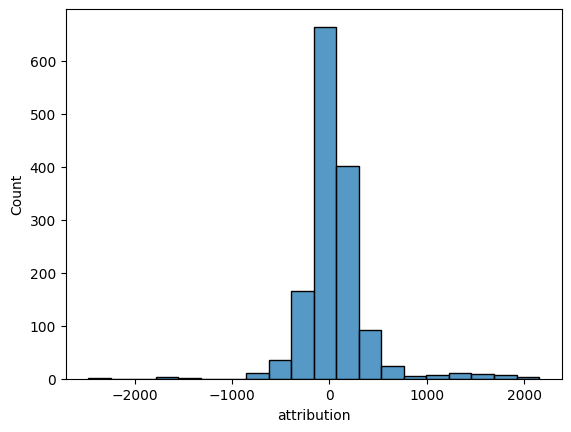

In [240]:
sns.histplot(data = df,x='attribution',bins=20)

In [253]:
standard1 = -10.46
standard2 = 9.511
near_zero_remove_index = df[(df['attribution']>standard1)
                            &(df['attribution']<standard2)].index
near_zero_remove_index

Int64Index([   1,  121,  125,  136,  143,  147,  151,  162,  169,  171,  178,
             182,  211,  213,  215,  222,  223,  224,  226,  227,  228,  230,
             240,  246,  288,  292,  294,  346,  349,  385,  387,  450,  459,
             480,  482,  483,  485,  501,  502,  513,  516,  518,  550,  552,
             564,  603,  608,  619,  631,  632,  641,  658,  712,  749,  893,
             895,  949,  964,  978, 1004, 1011, 1119, 1155, 1177, 1184, 1277,
            1280, 1300, 1305, 1313, 1326, 1360],
           dtype='int64')

In [255]:
near_zero_attr_weight = model._modules['first_layer'].weight.data.detach().\
                        cpu().numpy().reshape(-1)
near_zero_attr_weight[near_zero_remove_index] = 0 #q1과 q3사이에 있는 부분을 0
near_zero_attr_weight = FloatTensor(near_zero_attr_weight).view(1,-1).to(device)
near_zero_attr_weight.requires_grad = True
near_zero_attr_weight

tensor([[0.0009, 0.0000, 0.0015,  ..., 0.0225, 0.0226, 0.0237]],
       device='cuda:0', requires_grad=True)

In [257]:
model._modules['first_layer'].weight.data = near_zero_attr_weight

In [259]:
model._modules['first_layer'].weight.data.requires_grad = True

In [260]:
pred6 = model(X_test)
pred6= pred6.cpu().detach().view(-1,1)
sixth_result = criterion(pred6,target).item()*100
sixth_result

16.146093606948853

First_result의 결과는 다음과 같다. &rightarrow; 16.206350922584534

### TODO

&rightarrow; 모델도 초기화하고 optimizer도 초기화해서, attribution을 기반으로 weight를 점점 제거해서 성능보기 이를 반복해서 loss값 찍어보기(epoch도 다똑같이)


## Model 및 Optimizer 초기화

In [321]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0")
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100
criterion = SMAPE()

In [312]:
model._modules['first_layer'].weight.data

tensor([[0.0007, 0.0007, 0.0007,  ..., 0.0007, 0.0007, 0.0007]])

In [313]:
# 1std를 기준으로 +0.5std, -0,5std 사이에 해당하는 가중치를 0으로 설정
standard = (df.std()*0.5).values.item()
standard

171.24811222313866

In [314]:
zero_train_index = df[(df['attribution']<standard) & (df['attribution'] > -standard)].index
zero_train_index

Int64Index([   0,    1,    2,    3,    4,    5,    7,    8,   12,   97,
            ...
            1356, 1357, 1358, 1359, 1360, 1361, 1363, 1364, 1365, 1371],
           dtype='int64', length=899)

In [315]:
model._modules['first_layer'].weight.data.numpy().reshape(-1)[zero_train_index] = 0
model._modules['first_layer'].weight.data.numpy().reshape(-1)

array([0.        , 0.        , 0.        , ..., 0.00069444, 0.00069444,
       0.00069444], dtype=float32)

In [316]:
(model._modules['first_layer'].weight.data.numpy().reshape(-1)==0).sum()

899

In [323]:
model = model.to(device)

In [324]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    running_loss = 0.0

Epoch [1]/[100] running accumulative loss across all batches: 42.193
Epoch [21]/[100] running accumulative loss across all batches: 41.823
Epoch [41]/[100] running accumulative loss across all batches: 42.617
Epoch [61]/[100] running accumulative loss across all batches: 29.944
Epoch [81]/[100] running accumulative loss across all batches: 38.356


In [326]:
(model._modules['first_layer'].cpu().weight.data.numpy().reshape(-1)==0).sum()

0

## weight가 변함을 확인할 수 있음 이를 강제로 0으로 만들어주자

In [330]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0")
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100
criterion = SMAPE()

In [331]:
model = model.to(device)

In [332]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        model._modules['first_layer'].cpu().weight.data.numpy().reshape(-1)[zero_train_index] = 0
        model = model.to(device)
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    running_loss = 0.0

Epoch [1]/[100] running accumulative loss across all batches: 18.581
Epoch [21]/[100] running accumulative loss across all batches: 10.372
Epoch [41]/[100] running accumulative loss across all batches: 10.661
Epoch [61]/[100] running accumulative loss across all batches: 10.264
Epoch [81]/[100] running accumulative loss across all batches: 8.611


## running loss는 눈에띄게 줄었지만 아래의 test loss는 확 늘었다.

In [333]:
pred7 = model(X_test)
pred7= pred7.cpu().detach().view(-1,1)
seventh_result = criterion(pred7,target).item()*100
seventh_result

26.430627703666687

In [334]:
pred7

tensor([[118088.2344]])

In [335]:
target

tensor([[90520.]])

### 0.5std가 아닌  다른 비율로 똑같은 작업 수행해보기

In [343]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0")
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100
criterion = SMAPE()

In [344]:
# 1std를 기준으로 +0.5std, -0,5std 사이에 해당하는 가중치를 0으로 설정
standard = (df.std()).values.item()
standard

342.4962244462773

In [345]:
zero_train_index = df[(df['attribution']<standard) & (df['attribution'] > -standard)].index

In [346]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        model._modules['first_layer'].cpu().weight.data.numpy().reshape(-1)[zero_train_index] = 0
        model = model.to(device)
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    running_loss = 0.0

Epoch [1]/[100] running accumulative loss across all batches: 26.389
Epoch [21]/[100] running accumulative loss across all batches: 6.538
Epoch [41]/[100] running accumulative loss across all batches: 6.410
Epoch [61]/[100] running accumulative loss across all batches: 6.291
Epoch [81]/[100] running accumulative loss across all batches: 6.223


In [347]:
pred8 = model(X_test)
pred8= pred8.cpu().detach().view(-1,1)
eighth_result = criterion(pred8,target).item()*100
eighth_result

11.315973848104477

### Good Result

## TODO
### Epoch마다 attribution을 테스트해서 일정 비율 아래를 0으로 만들어서 수행해보기

In [351]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0")
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100
criterion = SMAPE()

In [ ]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        
        # check attribution on mid
        ig = IntegratedGradients(model)        
        nt_ig = NoiseTunnel(ig)
        nt_ig_attr_test = nt_ig.attribute(X_test)
        # X_test는 -split-sequence_length:-split 까지인 validation set과 같다.
        nt_ig_attr_test = nt_ig_attr_test.cpu().detach().numpy().reshape(-1)
        temp_df = pd.DataFrame({"attribution":nt_ig_attr_test})
        
        # train 시키지 않을 인덱스 추출
        standard = (temp_df.std()).values.item()
        zero_train_index = df[(df['attribution']<standard) & (df['attribution'] > -standard)].index
        
        # 해당 인덱스 가중치 0으로 조정
        model._modules['first_layer'].cpu().weight.data.numpy().reshape(-1)[zero_train_index] = 0
        model = model.to(device)
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    running_loss = 0.0

Epoch [1]/[100] running accumulative loss across all batches: 17.990
Epoch [21]/[100] running accumulative loss across all batches: 6.959
Epoch [41]/[100] running accumulative loss across all batches: 7.316
Epoch [61]/[100] running accumulative loss across all batches: 6.775
Epoch [81]/[100] running accumulative loss across all batches: 7.262


In [353]:
pred9 = model(X_test)
pred9= pred9.cpu().detach().view(-1,1)
nine_result = criterion(pred9,target).item()*100
nine_result

12.064555287361145

## ISSUE
### 1. loss를 Back ward시키기 전에 attribution=0로 수행을 해야하나?
### 2. 모든 index를 추적하면서 관리를 해야하나?
### 3. 앞으로 그 부분을 train 시키지 않기 위한 모델의 function을 만들어야 할듯
&rightarrow; 아래의 reset함수를 수행하면 될 것이다.

## 3번 문제에 대한 진행

In [360]:
A=torch.FloatTensor(np.arange(1440).reshape(-1,1))

In [361]:
B=torch.ones([1440,1])

In [377]:
C=A*B
C[[1,1439]] # Tensor도 Indexing 가능했음

tensor([[1.0000e+00],
        [1.4390e+03]])

In [373]:
C

tensor([[0.0000e+00],
        [1.0000e+00],
        [2.0000e+00],
        ...,
        [1.4370e+03],
        [1.4380e+03],
        [1.4390e+03]])

In [475]:
torch.ones([1,1440])

tensor([[1., 1., 1.,  ..., 1., 1., 1.]])

In [496]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq_len = 1440
        self.pred_len = 1
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x) 
    def reset_forward(self,x,idx): # idx는 attribution이 높은 것들의 index 리스트
        if idx == None: 
            return self.forward(x) # forward를 호출 클래스 내의 호출은 무조건 self를 붙여야 된다.
        weight_tensor = self.first_layer.weight
        weight_arr = weight_tensor.cpu().detach().numpy().reshape(-1)
        weight_arr = torch.FloatTensor(weight_arr[idx]) # 해당하는 인덱스만 뽑은후 텐서화
        weight_tensor = weight_arr.view(self.pred_len,-1)
        
        self.first_layer = nn.Linear(len(idx),self.pred_len)
        self.first_layer.weight = nn.Parameter(weight_tensor)
        
        return self.first_layer(x[idx]) # 새로 설정한 layer에 input을 집어넣음

In [501]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0")
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100
criterion = SMAPE()

RuntimeError: false INTERNAL ASSERT FAILED at "../c10/cuda/CUDAGraphsC10Utils.h":73, please report a bug to PyTorch. Unknown CUDA graph CaptureStatus32764

In [497]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0")
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100
criterion = SMAPE()

RuntimeError: false INTERNAL ASSERT FAILED at "../c10/cuda/CUDAGraphsC10Utils.h":73, please report a bug to PyTorch. Unknown CUDA graph CaptureStatus32764

In [498]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    train_index = None
    # check attribution on mid
    if epoch != 0:
        ig = IntegratedGradients(model)        
        nt_ig = NoiseTunnel(ig)
        nt_ig_attr_test = nt_ig.attribute(X_test)
        
        # X_test는 -split-sequence_length:-split 까지인 validation set과 같다.
        nt_ig_attr_test = nt_ig_attr_test.cpu().detach().numpy().reshape(-1)
        temp_df = pd.DataFrame({"attribution":nt_ig_attr_test})
        # train 시키지 않을 인덱스 추출
        standard = (temp_df.std()*0.1).values.item()
        train_index = list(df[(df['attribution']>standard) | (df['attribution'] < -standard)].index)
        
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        #print(epoch,train_index)
        outputs = model.reset_forward(inputs,idx = train_index)
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    running_loss = 0.0

RuntimeError: false INTERNAL ASSERT FAILED at "../c10/cuda/CUDAGraphsC10Utils.h":73, please report a bug to PyTorch. Unknown CUDA graph CaptureStatus32764

### Error로 인한 새로운 노트북에서 진행